In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *

Using Theano backend.


In [2]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import datetime
import multiprocessing as mp
import pickle
from functools import reduce

from skimage import measure, morphology, color
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

/Users/szalmaf/anaconda/envs/kaggle2017-2.7/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


# Set constants

In [3]:
# Some constants 
data_root = '/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/'

# Read in data

In [4]:
labeledImgs = load_array(data_root + 'images_3d_array-100x64x224x224.bc')

In [5]:
# save_array(arr=labeledImgs[:100], fname=data_root + 'images_3d_array-100x64x224x224.bc')

In [8]:
labeledPatients = pd.read_csv(data_root + 'labeled_patients_labels100.csv')

In [7]:
# labeledPatients[:100].to_csv(data_root + 'labeled_patients_labels100.csv', index=False)

# Set up trn and val sets

In [9]:
from sklearn.model_selection import train_test_split

trn,val = train_test_split(labeledImgs, test_size=0.2, random_state=42)

In [10]:
del labeledImgs

In [11]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

labels = onehot(np.array(np.int32(labeledPatients['cancer'])))
trn_labels, val_labels = train_test_split(labels, test_size=0.2, random_state=42)



# Set up model

## Load vgg, compile, and fit it. Save results

In [12]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(2)

/Users/szalmaf/anaconda/envs/kaggle2017-2.7/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [14]:
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
trn.shape

(80, 64, 224, 224)

In [13]:
# trn1 =  np.transpose(np.transpose(trn, [1,2,3,0])[31], [2,0,1]) # Pick 31st layer of each patient's image
# val1 = np.transpose(np.transpose(val, [1,2,3,0])[31], [2,0,1]) # Pick 31st layer of each patient's image

In [16]:
trn3 = trn.reshape(-1, trn.shape[2], trn.shape[3])

In [17]:
val3 = val.reshape(-1, val.shape[2], val.shape[3])

In [18]:
def fn(x): return np.transpose(color.gray2rgb(x), [2,0,1])

In [19]:
val3.nbytes

128450560

In [ ]:
# skip = val3.shape[0]/10
# val2 = np.zeros()
# for n in range(0, val3.shape[0], skip)
#     val = val3[n:n+skip]
#     val1 = np.array(map(fn, val))
#     val2 = 

In [21]:
%time val2 = np.array(map(fn, val3))

CPU times: user 368 ms, sys: 267 ms, total: 635 ms
Wall time: 634 ms


In [22]:
%time trn2 = np.array(map(fn, trn3))

CPU times: user 1.48 s, sys: 1.04 s, total: 2.52 s
Wall time: 2.52 s


In [24]:
val2.shape

(1280, 3, 224, 224)

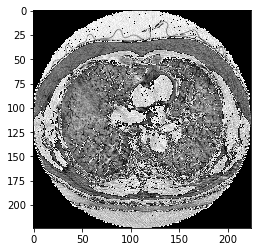

In [25]:
im = val2[31]
im.shape
plt.imshow(np.transpose(im, [1,2,0]))

In [26]:
batch_size = 8

In [31]:
model.fit(trn2, 
          trn_labels, 
          batch_size=batch_size, 
          nb_epoch=1, 
          validation_data=(val2, val_labels))

Train on 1117 samples, validate on 280 samples
Epoch 1/1
1117/1117 [==============================] - 691s - loss: 2.0200 - acc: 0.6204 - val_loss: 1.3840 - val_acc: 0.6500

In [33]:
model.save_weights(data_root+'results/ft1.h5')

## Pre-compute last conv layer in vgg

In [11]:
model.load_weights(path+'results/ft1.h5')

NameError: name 'model' is not defined

In [27]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [28]:
conv_model = Sequential(conv_layers)

In [ ]:
%time conv_val_feat = conv_model.predict(val2)

In [29]:
%time conv_feat = conv_model.predict(trn2)

KeyboardInterrupt: 

In [ ]:
conv_feat2 = conv_feat.reshape(trn.shape[0], trn.shape[1], conv_feat.shape[-3], conv_feat.shape[-2], conv_feat.shape[-1])

In [ ]:
conv_val_feat2 = conv_val_feat.reshape(val.shape[0], val.shape[1], conv_val_feat.shape[-3], conv_val_feat.shape[-2], conv_val_feat.shape[-1])

In [41]:
save_array(data_root+'results/conv_val_feat.dat', conv_val_feat2)
save_array(data_root+'results/conv_feat.dat', conv_feat2)

## Train 3-layer fully connected

In [ ]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [42]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(2, activation='softmax')
    ]

In [43]:
p=0.6

In [44]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [46]:
bn_model.fit(conv_feat, 
             trn_labels, 
             batch_size=batch_size, 
             nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 1117 samples, validate on 280 samples
Epoch 1/2
1117/1117 [==============================] - 29s - loss: 0.7676 - acc: 0.6661 - val_loss: 0.9610 - val_acc: 0.7500

In [ ]:
bn_model.optimizer.lr = 1e-4

In [ ]:
bn_model.fit(conv_feat, 
             trn_labels, 
             batch_size=batch_size, 
             nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

In [47]:
!git add image3d-vgg.ipynb

In [48]:
!git commit -m "Add image3d-vgg notebook"

[master a244254] Add image3d-vgg notebook
 1 file changed, 739 insertions(+)
 create mode 100644 image3d-vgg.ipynb


In [49]:
!git push origin master

Counting objects: 3, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 95.82 KiB | 0 bytes/s, done.
Total 3 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local objects.
remote: This repository moved. Please use the new location:
remote:   git@github.com:szalmaf/Linear_regression_to_Deep_Learning_in_Keras.git
To github.com:szalmaf/Linear_regression_in_Keras.git
   cd1b7eb..a244254  master -> master
